# Model Building, Evaluation, and Ensembling

In my previous writeup I have detailed about data cleaning and visualization of Titanic Survival and Hydrabad Housing price prediction problems.

In this write up I will explain the model building and evaluation.

First lets import the libraries that we are using in this notebook.

In [121]:
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

Now we read our dataset (clean data from the previous notebook) and separate the target variable from the dataset.

In [122]:
df = pd.read_csv('../data/titanic_clean_data.csv')
target = 'Survived'
features = [ col for col in df.columns if col != target ]
X, y = df[features], df[target]

Now its time to initialize our models. After initializing I am calculating the feature importances predicted by each model.

Note that I am passing a same random state to all the models. But why? 

Using this seed parameter makes sure that anyone who re-runs your code will get the exact same outputs which is extremely important concept in data science.

In [123]:
seed = 2
rf = RandomForestClassifier(random_state=seed)
et = ExtraTreesClassifier(random_state=seed)
ada = AdaBoostClassifier(random_state=seed)
gb = GradientBoostingClassifier(random_state=seed)

models = [rf, et, ada, gb]
model_names = ['RandomForest', 'ExtraTrees', 'Ada', 'GradientBoost']
[ m.fit(X, y) for m in models ]
feature_importances = { name: m.feature_importances_ for name, m in zip(model_names, models) }

Now we take a mean of feature importance calculated by each model.

In [124]:
feature_df = pd.DataFrame(feature_importances)
feature_df.insert(0, 'features', features)

feature_df['mean'] = feature_df.mean(axis=1)
feature_df

,features,RandomForest,ExtraTrees,Ada,GradientBoost,mean
0,Pclass,0.064775,0.071851,0.02,0.120943,0.069392
1,Sex,0.146110,0.191813,0.02,0.452222,0.202536
2,Age,0.146759,0.126773,0.36,0.106920,0.185113
3,Parch,0.020862,0.022891,0.06,0.001030,0.026196
4,Fare,0.145794,0.113324,0.16,0.125320,0.136110
5,Embarked,0.027991,0.035032,0.02,0.019782,0.025701
6,NameLength,0.155168,0.136444,0.14,0.061648,0.123315
7,HasCabin,0.035158,0.048121,0.04,0.042644,0.041481
8,FamilySize,0.047115,0.039543,0.14,0.058286,0.071236
9,IsAlone,0.011435,0.016270,0.00,0.000173,0.006970


From the above data, we can see that Sex, Age and Fare played important role in predicting the target variable Survived.

Now we import train_test_split from sklearn package for splitting the data into train and test sets.

Here I am taking 20% of the data for testing and the rest 80% for training.

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Voting Classifier is a machine learning model which ensembles predictions from a number of machine learning models and predicts the output based on voting.

So we are going to use voting classifier from sklearn for prediction.

Lets import the package and initialize the model and then fit the data in voting classifier.

In [126]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
    (name, m) for name, m in zip(model_names, models)
])

In [127]:
vc.fit(X, y)

VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(random_state=2)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(random_state=2)),
                             ('Ada', AdaBoostClassifier(random_state=2)),
                             ('GradientBoost',
                              GradientBoostingClassifier(random_state=2))])

Based on voting classifiers predictions lets calculate the cross validation scores. 

In [128]:
scores = cross_val_score(vc, X, y, cv=5, scoring='accuracy')
scores

array([0.81005587, 0.79775281, 0.84831461, 0.80898876, 0.84831461])

Now we fit the data and then compare our predictions with actual data to get accuracy.

In [129]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(random_state=2)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(random_state=2)),
                             ('Ada', AdaBoostClassifier(random_state=2)),
                             ('GradientBoost',
                              GradientBoostingClassifier(random_state=2))])

In [130]:
pred = vc.predict(X_test)
100. * (pred == y_test).mean()

79.88826815642457

Thats the accuracy we got.

------

Titanic Survival is a Binary classification problem. Our next model is a Regression model used for predicting housing prices of Hyderabad housing prices prediction problem from Kaggle. The data cleaning and visualization parts have already been shared in my previous writeups.

Model building and evaluation for both binary classification and Regression are more similar.

Lets import the libraries we use to build the regression model.

In [131]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew

Now lets read the train and test datasets, cleaned up in previous notebooks.

In [132]:
train = pd.read_csv('../data/clean_train-hpp.csv')

In [133]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,...,0,None,None,None,0,2,2008,WD,Normal,2566.0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,...,0,None,None,None,0,5,2007,WD,Normal,2524.0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,...,0,None,None,None,0,9,2008,WD,Normal,2706.0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,...,0,None,None,None,0,2,2006,WD,Abnorml,2473.0
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,...,0,None,None,None,0,12,2008,WD,Normal,3343.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,None,Reg,Lvl,Inside,Gtl,...,0,None,None,None,0,8,2007,WD,Normal,2600.0
1456,20,RL,85.0,13175,Pave,None,Reg,Lvl,Inside,Gtl,...,0,None,MnPrv,None,0,2,2010,WD,Normal,3615.0
1457,70,RL,66.0,9042,Pave,None,Reg,Lvl,Inside,Gtl,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,3492.0
1458,20,RL,68.0,9717,Pave,None,Reg,Lvl,Inside,Gtl,...,0,None,None,None,0,4,2010,WD,Normal,2156.0


In [134]:
y_train = pd.read_csv('../data/clean_y_train-hpp.csv')

In [135]:
y_train

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


In [136]:
train.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [137]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'MSZoning', 'LandContour', 'LotConfig')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))

# shape        
print('Shape of train data: {}'.format(train.shape))

Shape of train data: (1460, 79)


# Skewness
    
In normal distribution, the graph looks symmertrical meaning that the number of data on the right side is more or less equal to the number of data on the left side. In this case the mean, meadian and mode of the data is more or less same.

If the curve is bigger on the left side it means the data is positively skewed. In this case the mean and median are greater than mode and the mean is greater than the median value. Similarly, if the curver is bigger on the right sider, the data is negatively skewed.

If the data is skewed, the tail side of the graph will contain the outliers and that will affect the performance of the model especially in regression problems.

To fix the skewness in the dataset, we generally use several methods. Some of the methods used are
1. Scalling
2. Log Transformation
3. Cube root Noralization
4. Box-Cox Transformation.

Some important things to remember before using one of the above methods are

1. These techniques are used to convert the dataset into smaller values
2. we use these techniques if the data has too many extreme values.
3. These techniques will not alwats gives best results
4. There is no loss of data from using these methods

Box-Cox Transformation gives best result among all the above methods. Hence we use Box-Cox Transformation in this problem.

In [138]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
LandSlope,4.808735
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186


# Box Cox Transformation of (highly) skewed features

In [139]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:

    train[feat] = boxcox1p(train[feat], lam)

There are 62 skewed numerical features to Box Cox transform


In [140]:
df = pd.get_dummies(train)
print(df.shape)

(1460, 210)


In [141]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.055642,1.540963,5.831328,19.212182,0.730463,0.730463,1.540963,1.540963,1.820334,0.0,...,0,0,0,1,0,0,0,0,1,0
1,0.000000,1.540963,6.221214,19.712205,0.730463,0.730463,1.540963,1.540963,1.194318,0.0,...,0,0,0,1,0,0,0,0,1,0
2,2.055642,1.540963,5.914940,20.347241,0.730463,0.730463,0.000000,1.540963,1.820334,0.0,...,0,0,0,1,0,0,0,0,1,0
3,2.259674,1.540963,5.684507,19.691553,0.730463,0.730463,0.000000,1.540963,0.000000,0.0,...,0,0,0,1,1,0,0,0,0,0
4,2.055642,1.540963,6.314735,21.325160,0.730463,0.730463,0.000000,1.540963,1.194318,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2.055642,1.540963,5.744420,18.960528,0.730463,0.730463,1.540963,1.540963,1.820334,0.0,...,0,0,0,1,0,0,0,0,1,0
1456,0.000000,1.540963,6.337529,20.994868,0.730463,0.730463,1.540963,1.540963,1.820334,0.0,...,0,0,0,1,0,0,0,0,1,0
1457,2.259674,1.540963,5.859551,19.476345,0.730463,0.730463,1.540963,1.540963,1.820334,0.0,...,0,0,0,1,0,0,0,0,1,0
1458,0.000000,1.540963,5.914940,19.760176,0.730463,0.730463,1.540963,1.540963,1.820334,0.0,...,0,0,0,1,0,0,0,0,1,0


Now lets initialize our Regression models. As explained earlier I am passing a common random state to all models to ensure reproducibility.

In [142]:
seed=5
lasso = Lasso(random_state=seed)
ENet = ElasticNet(random_state=seed)
GBoost = GradientBoostingRegressor(random_state =seed)
model_xgb = xgb.XGBRegressor(random_state =seed)
model_lgb = lgb.LGBMRegressor(random_state =seed)

Now we assign the training dataset as X and y_train dataset as y. Later we will split the data using train_test_split.

In [143]:
X, y = train, y_train

Now lets calculate the mean score of each model and print it to see which model performs better.

In [144]:
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

model_names = ['Lasso', 'ElasticNet', 'GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor']
models =  [lasso, ENet, GBoost, model_xgb, model_lgb]
mean_score = []
for model in models:
    scores = cross_val_score(model, X, y.SalePrice, cv=10, scoring='neg_mean_squared_error')
    mean_score.append(-1 * scores.mean())


/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py", line 759, in fit
    X, y = self._validate_data(X, y, accept_sparse='csc',
  File "/usr/local/lib/python3.8/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 796, in check_X_y
    X = check_array(X, accept_sparse=accept_sparse,
  File "/u

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 409, in fit
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc', 'coo'],
  File "/usr/local/lib/python3.8/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 796, in check_X_y
    X = check_array(X, accept_sparse=accept_sparse,
  File "/usr/l

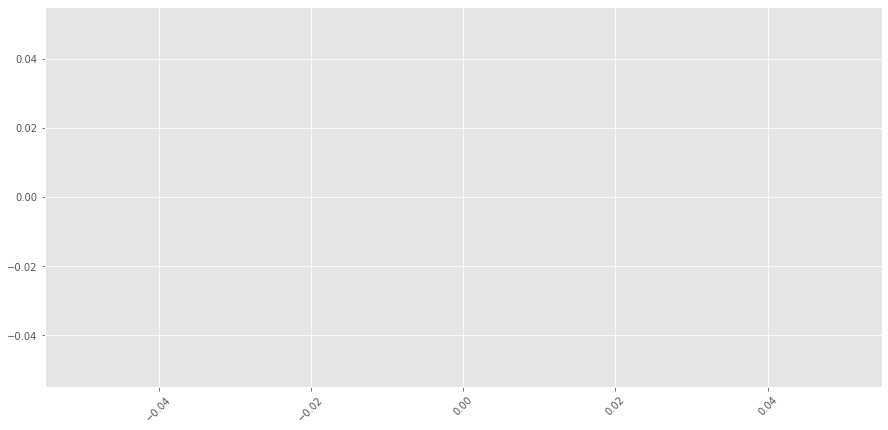

In [145]:
plt.figure(figsize=(15, 7))
g = sns.scatterplot(x=model_names, y=mean_score, hue=mean_score, s=200)
plt.xticks(rotation=45);
plt.show();

From the above graph Gradient Boosting Regressor performs better than other models. Hence we choose this model for prediction.

In [146]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
GBoost.fit(X_train, y_train)
y_pred = GBoost.predict(X_test)
y_real = y_test.SalePrice
MAPE = abs((y_real - y_pred) / y_real).mean()

ValueError: could not convert string to float: 'Timber'

We have calculated MAPE (Mean Absolute Percentage Error). MAPE is a performance metric for regression problems.

Now we just calcualte accuracy of the model.

In [ ]:
100. - (100. * MAPE)